<a href="https://colab.research.google.com/github/Anuvarshaj/-Plant-Disease-Classification-using-Self-Supervised-Vision-Transformer-with-Metadata-Fusion/blob/main/plant_disease_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")

print("Path to dataset files:", path)



Path to dataset files: /kaggle/input/new-plant-diseases-dataset


In [10]:
import os
from pathlib import Path
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# The path you printed earlier
dataset_root = Path(path) / "New Plant Diseases Dataset(Augmented)" / "New Plant Diseases Dataset(Augmented)"

train_dir = dataset_root / "train"
valid_dir = dataset_root / "valid"

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

train_dataset = ImageFolder(str(train_dir), transform=transform)
valid_dataset = ImageFolder(str(valid_dir), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# Preview shapes
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32])


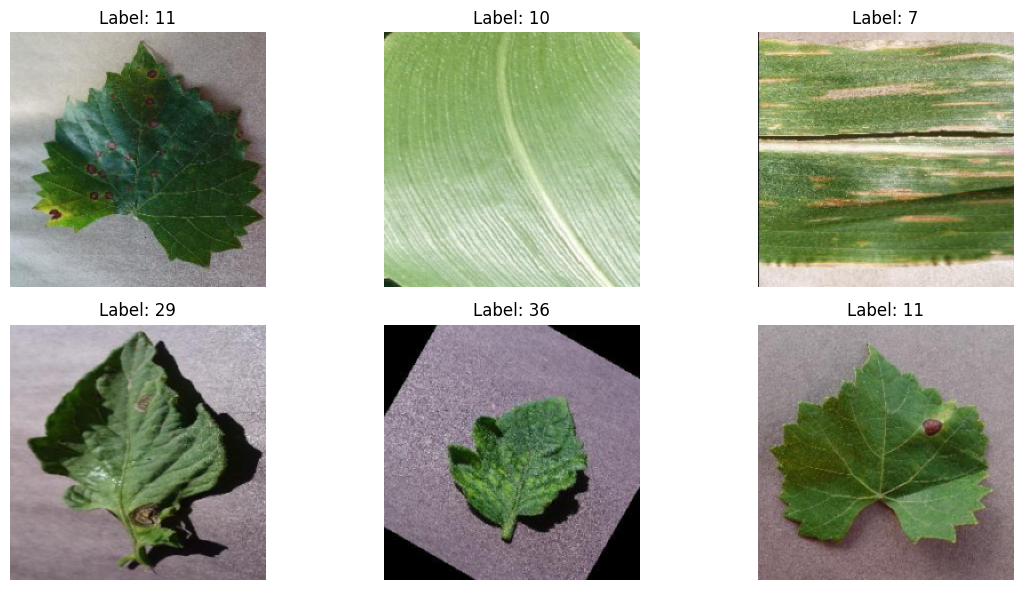

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
for i in range(6): # Show first 6 images in a batch
    plt.subplot(2,3,i+1)
    img = images[i].permute(1,2,0) # Change from [C,H,W] to [H,W,C]
    plt.imshow(img)
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()


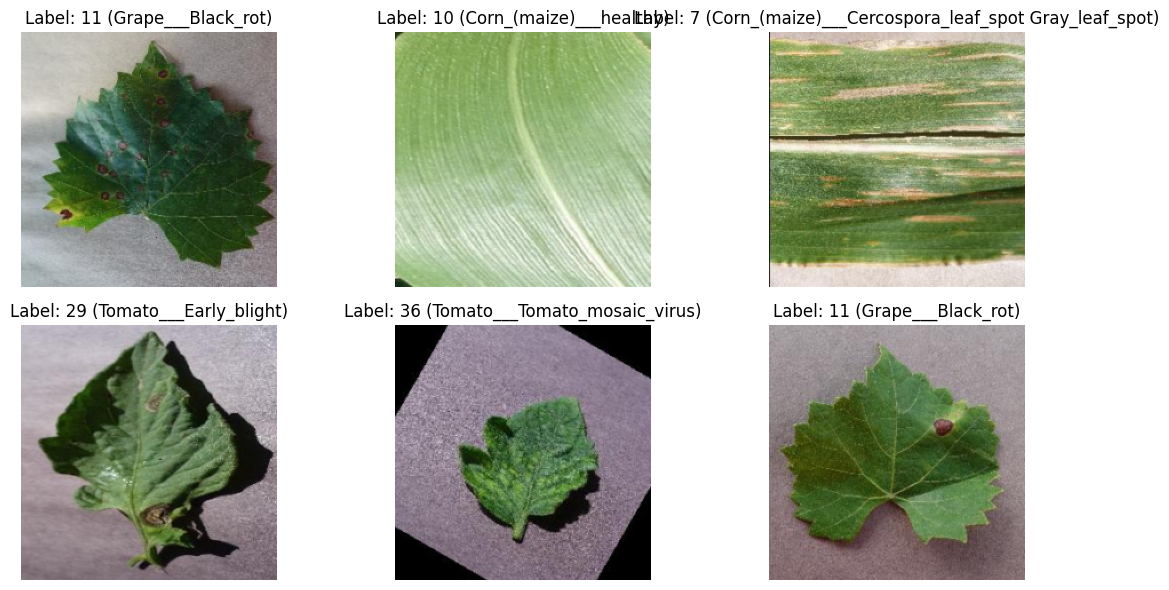

In [13]:
# This gets the class-to-index mapping
disease_names = train_dataset.classes  # train_dataset from previous code

# Visualize with disease name instead of label number
plt.figure(figsize=(12,6))
for i in range(6):
    plt.subplot(2,3,i+1)
    img = images[i].permute(1,2,0)
    plt.imshow(img)
    label_idx = labels[i].item()
    plt.title(f"Label: {label_idx} ({disease_names[label_idx]})")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [14]:
import torch
from transformers import ViTModel, ViTConfig

# Load pretrained ViT base model
vit_model = ViTModel.from_pretrained('facebook/dino-vitb16')

# Check output feature size (usually 768 for ViT Base)
print(vit_model.config.hidden_size)

# Freeze parameters if you want to fine-tune later or train end-to-end
for param in vit_model.parameters():
    param.requires_grad = True  # Set False to freeze


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/343M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


768


In [23]:
import torch
import torch.nn as nn

class MultiModalPlantDiseaseClassifier(nn.Module):
    def __init__(self, vit_model, metadata_dim=8, num_classes=38):
        super().__init__()
        self.vit = vit_model
        self.metadata_mlp = nn.Sequential(
            nn.Linear(metadata_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        self.classifier = nn.Linear(768 + 16, num_classes)  # 768 is ViT base feature size

    def forward(self, images, metadata):
        vit_outputs = self.vit(images).last_hidden_state[:, 0]  # CLS token output
        meta_features = self.metadata_mlp(metadata)
        combined = torch.cat([vit_outputs, meta_features], dim=1)
        logits = self.classifier(combined)
        return logits


In [20]:
model = MultiModalPlantDiseaseClassifier(vit_model, metadata_dim=8, num_classes=len(train_dataset.classes))
model.to(device)


MultiModalPlantDiseaseClassifier(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (i